### This file contains data visualization, feature engineering, trained LSTM and AE models.
### Authors: Lisa Kim, Evian Liu

### Sources:
- https://machinelearningmastery.com/lstm-autoencoders/
- https://bobrupakroy.medium.com/lstm-autoencoders-a45a04667346
- https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352
- https://stackoverflow.com/questions/68844792/lstm-will-not-use-cudnn-kernels-since-it-doesnt-meet-the-criteria-it-will-use


In [ ]:
from IPython.display import HTML
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')

} else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });e
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

## Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, warnings, random

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras import optimizers, Sequential, Model
from keras.utils.vis_utils import plot_model
from keras.layers import Dropout, Bidirectional

Mounted at /content/drive


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
1.5072450760000038
GPU (s):
0.03864111600000797
GPU speedup over CPU: 39x


## Data and Visualization

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/new_test.csv')
train = pd.read_csv('/content/drive/MyDrive/new_train.csv')

features = train[['R', 'C', 'u_in', 'u_out']]
response = train[['pressure']]

features_test = test[['R', 'C', 'u_in', 'u_out']]
response_test = test[['pressure']]

train_num = train['breath_id'].nunique()
test_num = test['breath_id'].nunique()

features_3d = features.values.reshape(train_num, 80, 4)
response_3d = response.values.reshape(train_num, 80, 1)

features_test_3d = features_test.values.reshape(test_num, 80, 4)
response_test_3d = response_test.values.reshape(test_num, 80, 1)

train.head()

,Unnamed: 0,breath_id,R,C,time_step,u_in,u_out,pressure
0,0,1,20,50,0.000000,0.083334,0,5.837492
1,1,1,20,50,0.033652,18.383041,0,5.907794
2,2,1,20,50,0.067514,22.509278,0,7.876254
3,3,1,20,50,0.101542,22.808822,0,11.742872
4,4,1,20,50,0.135756,25.355850,0,12.234987


In [ ]:
grouped = train.groupby(['R','C','u_out']).mean().drop(['Unnamed: 0','breath_id'], axis=1)
grouped

time_step       u_in   pressure
R  C  u_out                                 
5  10 0       0.486288   8.950664  19.322935
      1       1.829319   2.920353   7.159101
   20 0       0.485088  20.959541  16.264359
      1       1.785584   2.812181   7.958650
   50 0       0.483539  33.969626  14.687460
      1       1.832905   2.940928   7.602759
20 10 0       0.487287   8.518255  19.972479
      1       1.818181   2.885981   7.131816
   20 0       0.483053  15.002665  17.857336
      1       1.820592   2.911266   7.259711
   50 0       0.482787  21.160957  16.512510
      1       1.830071   2.933295   7.329311
50 10 0       0.485678   6.604332  17.355515
      1       1.801669   3.221986   6.904996
   20 0       0.488843   9.624977  19.441772
      1       1.795104   2.826458   7.503980
   50 0       0.485236  10.238163  17.850220
      1       1.784837   2.799247   7.259825

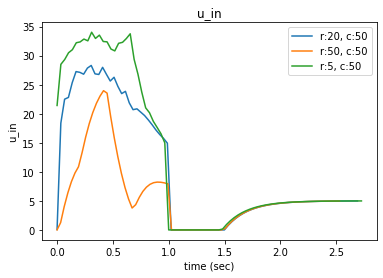

In [ ]:
patient1 = train[train['breath_id']==1]
plt.plot(patient1['time_step'], patient1['u_in'], label='r:20, c:50')
patient2 = train[train['breath_id']==2]
plt.plot(patient2['time_step'], patient2['u_in'], label='r:50, c:50')
patient3 = train[train['breath_id']==3]
plt.plot(patient3['time_step'], patient3['u_in'], label='r:5, c:50')

patient4 = train[train['breath_id']==5]
patient5 = train[train['breath_id']==6]
patient6 = train[train['breath_id']==12]
patient7 = train[train['breath_id']==13]
patient8 = train[train['breath_id']==19]
patient9 = train[train['breath_id']==45]

plt.xlabel('time (sec)')
plt.legend()
plt.title('u_in')
plt.ylabel('u_in');

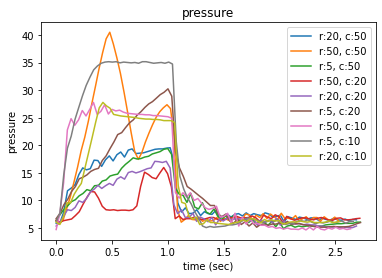

In [ ]:
patient1 = train[train['breath_id']==1]
plt.plot(patient1['time_step'], patient1['pressure'], label='r:20, c:50')
patient2 = train[train['breath_id']==2]
plt.plot(patient2['time_step'], patient2['pressure'], label='r:50, c:50')
patient3 = train[train['breath_id']==3]
plt.plot(patient3['time_step'], patient3['pressure'], label='r:5, c:50')
patient4 = train[train['breath_id']==5]
plt.plot(patient4['time_step'], patient4['pressure'], label='r:50, c:20')
patient5 = train[train['breath_id']==6]
plt.plot(patient5['time_step'], patient5['pressure'], label='r:20, c:20')
patient6 = train[train['breath_id']==12]
plt.plot(patient6['time_step'], patient6['pressure'], label='r:5, c:20')
patient7 = train[train['breath_id']==13]
plt.plot(patient7['time_step'], patient7['pressure'], label='r:50, c:10')
patient8 = train[train['breath_id']==19]
plt.plot(patient8['time_step'], patient8['pressure'], label='r:5, c:10')
patient9 = train[train['breath_id']==45]
plt.plot(patient9['time_step'], patient9['pressure'], label='r:20, c:10')

plt.xlabel('time (sec)')
plt.legend()
plt.title('pressure')
plt.ylabel('pressure');

## Feature engineering

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/new_test.csv')
train = pd.read_csv('/content/drive/MyDrive/new_train.csv')

In [ ]:
def add_features(df):
    df['cross']= df['u_in'] * df['u_out']
    df['cross2']= df['time_step'] * df['u_out']
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['time_step_cumsum'] = df.groupby(['breath_id'])['time_step'].cumsum()
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    print("Step-1...Completed")
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    print("Step-2...Completed")
    
    df['breath_id_u_in_max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id_u_in_mean'] = df.groupby(['breath_id'])['u_in'].transform('mean')
    df['breath_id_u_in_diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id_u_in_diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']

    print("Step-3...Completed")
    
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    print("Step-4...Completed")
    
    df['one'] = 1
    df['count'] = (df['one']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] =df['u_in_cumsum'] /df['count']
    
    df['breath_id_lag']=df['breath_id'].shift(1).fillna(0)
    df['breath_id_lag2']=df['breath_id'].shift(2).fillna(0)
    df['breath_id_lagsame']=np.select([df['breath_id_lag']==df['breath_id']],[1],0)
    df['breath_id_lag2same']=np.select([df['breath_id_lag2']==df['breath_id']],[1],0)
    df['breath_id__u_in_lag'] = df['u_in'].shift(1).fillna(0)
    df['breath_id__u_in_lag'] = df['breath_id__u_in_lag'] * df['breath_id_lagsame']
    df['breath_id__u_in_lag2'] = df['u_in'].shift(2).fillna(0)
    df['breath_id__u_in_lag2'] = df['breath_id__u_in_lag2'] * df['breath_id_lag2same']
    print("Step-5...Completed")
    
    df['time_step_diff'] = df.groupby('breath_id')['time_step'].diff().fillna(0)
    df['ewm_u_in_mean'] = (df\
                           .groupby('breath_id')['u_in']\
                           .ewm(halflife=9)\
                           .mean()\
                           .reset_index(level=0,drop=True))
    df[["15_in_sum","15_in_min","15_in_max","15_in_mean"]] = (df\
                                                              .groupby('breath_id')['u_in']\
                                                              .rolling(window=15,min_periods=1)\
                                                              .agg({"15_in_sum":"sum",
                                                                    "15_in_min":"min",
                                                                    "15_in_max":"max",
                                                                    "15_in_mean":"mean"
                                                                    #"15_in_std":"std"
                                                               })\
                                                               .reset_index(level=0,drop=True))
    print("Step-6...Completed")
        
    df['u_in_lagback_diff1'] = df['u_in'] - df['u_in_lag_back1']
    df['u_out_lagback_diff1'] = df['u_out'] - df['u_out_lag_back1']
    df['u_in_lagback_diff2'] = df['u_in'] - df['u_in_lag_back2']
    df['u_out_lagback_diff2'] = df['u_out'] - df['u_out_lag_back2']
    print("Step-7...Completed")
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R_C'] = df["R"].astype(str) + '_' + df["C"].astype(str)
    df = pd.get_dummies(df)
    print("Step-8...Completed")
    
    return df

train = add_features(train)
test = add_features(test)

X_test = test.drop(['Unnamed: 0','breath_id','pressure'], axis = 1)
X_train = train.drop(['Unnamed: 0','breath_id','pressure'], axis = 1)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# transform data
X_train = scaler.fit_transform(X_train)
scaler = MinMaxScaler()
# transform data
X_test = scaler.fit_transform(X_test)

Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed
Step-6...Completed
Step-7...Completed
Step-8...Completed
Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed
Step-6...Completed
Step-7...Completed
Step-8...Completed


In [ ]:
features = X_train
response = train[['pressure']]

features_test = X_test
response_test = test[['pressure']]

train_num = train['breath_id'].nunique()
test_num = test['breath_id'].nunique()

features_3d = features.reshape(train_num, 80, X_train.shape[1])
response_3d = response.values.reshape(train_num, 80, 1)

features_test_3d = features_test.reshape(test_num, 80, X_train.shape[1])
response_test_3d = response_test.values.reshape(test_num, 80, 1)

## Basic LSTM

In [ ]:
# reguler LSTM

serie_size =  features_3d.shape[1] # 80
n_features =  features_3d.shape[2] # 4

epochs = 20
batch = 128
lr = 0.001

lstm_model = Sequential()
lstm_model.add(L.LSTM(150, activation='tanh', input_shape=(serie_size, n_features), return_sequences=True))
lstm_model.add(L.LSTM(1, return_sequences=True))

lstm_model.add(L.Dense(150, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(L.Dense(1, kernel_initializer='glorot_normal'))
lstm_model.summary()

adam = optimizers.Adam(lr)
lstm_model.compile(loss='mae', optimizer=adam)

lstm_history = lstm_model.fit(features_3d, response_3d, 
                              validation_data=(features_test_3d, response_test_3d), 
                              batch_size=batch, 
                              epochs=epochs, 
                              verbose=2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 80, 150)           132600    
                                                                 
 lstm_7 (LSTM)               (None, 80, 1)             608       
                                                                 
 dense_1 (Dense)             (None, 80, 150)           300       
                                                                 
 dense_2 (Dense)             (None, 80, 1)             151       
                                                                 
Total params: 133,659
Trainable params: 133,659
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
472/472 - 11s - loss: 6.1398 - val_loss: 5.0415 - 11s/epoch - 24ms/step
Epoch 2/20
472/472 - 6s - loss: 2.4109 - val_loss: 1.0531 - 6s/epoch - 13ms/step
Epoch 3/20
472/4

In [ ]:
lstm_pred = lstm_model.predict(features_test_3d)
lstm_mae = np.mean(np.abs(lstm_pred - response_test_3d), axis=1)
np.mean(lstm_mae)
#lstm_model.evaluate(features_test_3d, response_test_3d)

0.5469052277817844

In [ ]:
np.savetxt("/content/drive/MyDrive/LSTM.txt", lstm_pred[0,:], delimiter =", ")
np.savetxt("/content/drive/MyDrive/LSTM_full.txt", lstm_pred.reshape(test_num*80, 1), delimiter =", ")


In [ ]:
test_orig = pd.read_csv('/content/drive/MyDrive/new_test.csv')

pred_results = test_orig[["R","C"]][test_orig.index % 80 == 0] 
pred_results["pred"] = lstm_mae
pred_results.groupby(['R', 'C']).mean()

pred
R  C           
5  10  0.493916
   20  0.429644
   50  0.363047
20 10  0.484317
   20  0.477409
   50  0.499383
50 10  0.774157
   20  0.594099
   50  0.630372

## LSTM-AE

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 80, 500)           1142000   
                                                                 
 dropout (Dropout)           (None, 80, 500)           0         
                                                                 
 lstm_7 (LSTM)               (None, 80, 100)           240400    
                                                                 
 lstm_8 (LSTM)               (None, 20)                9680      
                                                                 
 repeat_vector_1 (RepeatVect  (None, 80, 20)           0         
 or)                                                             
                                                                 
 lstm_9 (LSTM)               (None, 80, 20)            3280      
                                                      

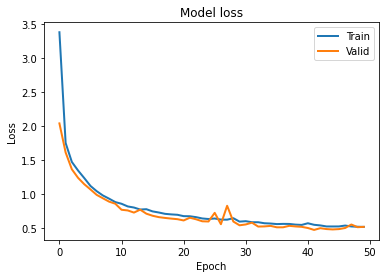

In [ ]:
# reguler LSTM w/ wide bottleneck
serie_size =  features_3d.shape[1] # 80
n_features =  features_3d.shape[2] # 4

encoder_decoder = Sequential()
encoder_decoder.add(L.LSTM(500, activation='tanh', input_shape=(serie_size, n_features), return_sequences=True))
encoder_decoder.add(Dropout(0.2))
encoder_decoder.add(L.LSTM(100, activation='tanh', return_sequences=True))
encoder_decoder.add(L.LSTM(20, activation='tanh', return_sequences=False))

encoder_decoder.add(L.RepeatVector(serie_size))

encoder_decoder.add(L.LSTM(20, activation='tanh', return_sequences=True))
encoder_decoder.add(L.LSTM(100, activation='tanh', return_sequences=True))
encoder_decoder.add(L.LSTM(500, activation='tanh', return_sequences=True))
encoder_decoder.add(Dropout(0.2))
encoder_decoder.add(L.TimeDistributed(L.Dense(1)))
encoder_decoder.summary()
plot_model(encoder_decoder, show_shapes=True, to_file='val_loss.png')


# reguler LSTM， lr = 0.001
epochs = 50
batch = 128
lr = 0.001

adam = optimizers.Adam(lr)
encoder_decoder.compile(loss='mae', optimizer=adam)

encoder_decoder_history = encoder_decoder.fit(features_3d, response_3d, 
                              validation_split=0.1, 
                              batch_size=batch, 
                              epochs=epochs, 
                              verbose=2)

plt.plot(encoder_decoder_history.history['loss'], linewidth=2, label='Train')
plt.plot(encoder_decoder_history.history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
X_train_pred = encoder_decoder.predict(features_test_3d)
pred_mae = np.mean(np.abs(X_train_pred - response_test_3d), axis=1)
np.mean(pred_mae)

0.5381638779710507

In [ ]:
encoder_decoder.evaluate(features_test_3d, response_test_3d) 

472/472 [==============================] - 10s 20ms/step - loss: 0.5382


0.538163959980011

In [ ]:
test_orig = pd.read_csv('/content/drive/MyDrive/new_test.csv')
pred_results = test_orig[["R","C"]][test_orig.index % 80 == 0] 
pred_results["pred"] = pred_mae
pred_results.groupby(['R', 'C']).mean()

pred
R  C           
5  10  0.438792
   20  0.355037
   50  0.369093
20 10  0.427257
   20  0.432992
   50  0.520845
50 10  0.576854
   20  0.795987
   50  0.858469

## LSTM-AE Bidirectional

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (60360, 80, 1000)        2284000   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (60360, 80, 200)         880800    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (60360, 40)              35360     
 nal)                                                            
                                                                 
 repeat_vector (RepeatVector  (60360, 80, 40)          0         
 )                                                               
                                                                 
 lstm_3 (LSTM)               (60360, 80, 20)           4

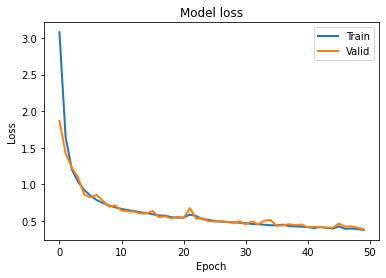

In [ ]:
# reguler LSTM w/ wide bottleneck
n_patient = features_3d.shape[0]
serie_size =  features_3d.shape[1] # 80
n_features =  features_3d.shape[2] # 4

encoder_decoder = Sequential()
encoder_decoder.add(Bidirectional(L.LSTM(500, activation='tanh', input_shape=(serie_size, n_features), return_sequences=True)))
encoder_decoder.add(Bidirectional(L.LSTM(100, activation='tanh', return_sequences=True)))
encoder_decoder.add(Bidirectional(L.LSTM(20, activation='tanh', return_sequences=False)))

encoder_decoder.add(L.RepeatVector(serie_size))

encoder_decoder.add(L.LSTM(20, activation='tanh', return_sequences=True))
encoder_decoder.add(L.LSTM(100, activation='tanh', return_sequences=True))
encoder_decoder.add(L.LSTM(500, activation='tanh', return_sequences=True))
encoder_decoder.add(L.TimeDistributed(L.Dense(1)))

encoder_decoder.build((n_patient, serie_size, n_features))

encoder_decoder.summary()
plot_model(encoder_decoder, show_shapes=True, to_file='val_loss.png')


# reguler LSTM， lr = 0.001
epochs = 50
batch = 128
lr = 0.001

adam = optimizers.Adam(lr)
encoder_decoder.compile(loss='mae', optimizer=adam)

encoder_decoder_history = encoder_decoder.fit(features_3d, response_3d, 
                              validation_split=0.1, 
                              batch_size=batch, 
                              epochs=epochs, 
                              verbose=2)

plt.plot(encoder_decoder_history.history['loss'], linewidth=2, label='Train')
plt.plot(encoder_decoder_history.history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
X_test_pred = encoder_decoder.predict(features_test_3d)
#np.savetxt("/content/drive/MyDrive/LSTM_AE.txt", X_test_pred[0,:], delimiter =", ")
pred_mae = np.mean(np.abs(X_test_pred - response_test_3d), axis=1)
np.mean(pred_mae)
#encoder_decoder.evaluate(features_test_3d, response_test_3d) 


0.3809272594801234

In [ ]:
test_orig = pd.read_csv('/content/drive/MyDrive/new_test.csv')

test_orig["AE_pred"] = X_test_pred.reshape(test_num*80, 1)
#np.savetxt("/content/drive/MyDrive/LSTM_AE_full.txt", X_test_pred.reshape(test_num*80, 1), delimiter =", ")

pred_results = test_orig[["R","C"]][test_orig.index % 80 == 0] 
pred_results["pred"] = pred_mae
pred_results.groupby(['R', 'C']).mean()

pred
R  C           
5  10  0.317563
   20  0.274164
   50  0.298126
20 10  0.324969
   20  0.327570
   50  0.371331
50 10  0.400756
   20  0.530982
   50  0.549120

Text(0.5, 1.0, 'Sample Patient Pressure Prediction')

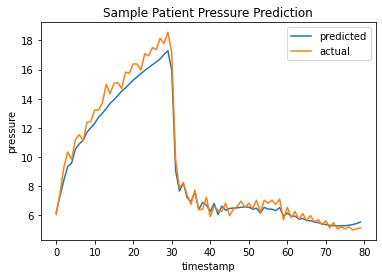

In [ ]:
plt.plot(X_test_pred[0,:], label='predicted')
plt.plot(response_test_3d[0,:], label='actual')
plt.xlabel("timestamp")
plt.ylabel("pressure")
plt.legend()
plt.title("Sample Patient Pressure Prediction")

## Results

In [ ]:
sns.color_palette("Set2") #"Paired", "pastel", "muted", "Set2"

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

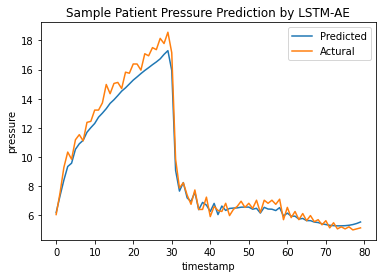

In [ ]:
plt.plot(X_test_pred[0,:], label="Predicted")
plt.plot(response_test_3d[0,:], label="Actural")
plt.legend()
plt.xlabel("timestamp")
plt.ylabel("pressure")
_ = plt.title("Sample Patient Pressure Prediction by LSTM-AE")

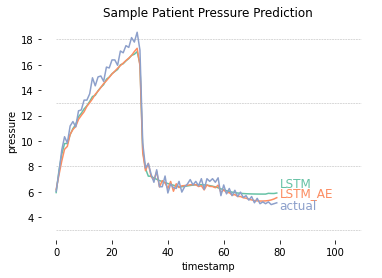

In [ ]:
# plot all model predictions for the first test patient
for y in range(3, 21, 5):    
    plt.plot(range(0, 110), [y] * 110, "--", lw=0.5, color="black", alpha=0.3)   
plt.box(on=None)


plt.plot(lstm_pred[0,:], color=sns.color_palette("Set2")[0])
plt.plot(X_test_pred[0,:], color=sns.color_palette("Set2")[1])
plt.plot(response_test_3d[0,:], color=sns.color_palette("Set2")[2])


plt.text(80, lstm_pred[0,-1]+0.5, "LSTM", fontsize=12, 
         color=sns.color_palette("Set2")[0])
plt.text(80, X_test_pred[0,-1]+0.1, "LSTM_AE", fontsize=12, 
         color=sns.color_palette("Set2")[1])
plt.text(80, response_test_3d[0,-1]-0.5, "actual", fontsize=12, 
         color=sns.color_palette("Set2")[2])


plt.xlabel("timestamp")
plt.ylabel("pressure")
_ = plt.title("Sample Patient Pressure Prediction")

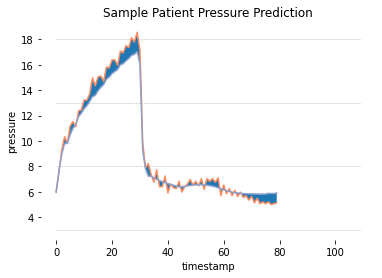

In [ ]:
# plot all model predictions for the first test patient
for y in range(3, 21, 5):    
    plt.plot(range(0, 110), [y] * 110, "--", lw=0.5, color="black", alpha=0.3)   
plt.box(on=None)

plt.plot(response_test_3d[0,:], color=sns.color_palette("Set2")[1])
plt.plot(lstm_pred[0,:], color=sns.color_palette("Set2")[2])
plt.fill_between(np.arange(80), lstm_pred[0,:].flatten(), response_test_3d[0,:].flatten())
#plt.fill_between(np.arange(80), X_test_pred[0,:].flatten(), response_test_3d[0,:].flatten())

plt.xlabel("timestamp")
plt.ylabel("pressure")
_ = plt.title("Sample Patient Pressure Prediction")